## Neural Networks for MNIST dataset

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd

### Loading MNIST
Here we load the dataset and create data loaders.

In [7]:
train_ds = datasets.MNIST('../data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('../data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [5]:
batch_size = 64
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

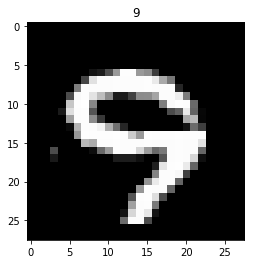

In [6]:
train_dl = iter(train_loader)
x, y = next(train_dl)

def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)
        
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

show(X[0][0], Y[0])

### Model Setting

In [6]:
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net.cuda()

In [7]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    for epoch in range(num_epochs):
        model.train()
        total = 0
        sum_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = Variable(images.view(-1, 28*28)).cuda()
            labels = Variable(labels).cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.data[0]
        train_loss = sum_loss/total
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        
    return val_acc, val_loss, train_loss

In [8]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28)).cuda()
        labels = Variable(labels).cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.data[0]
        total += labels.size(0)
        correct += pred.eq(labels.data).cpu().sum()
    return 100 * correct / total, sum_loss/ total

## 1: Explore learning rate

In [9]:
def train_lr(lr):
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, 
                                                 num_epochs=10, model=net, optimizer=optimizer)
    return val_acc, val_loss

In [10]:
lr_grid = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
lval_acc = []
lval_loss = []
for lr in lr_grid:
    val_acc, val_loss = train_lr(lr)
    lval_acc.append(val_acc)
    lval_loss.append(val_loss)

In [11]:
data = [('Learning_rate', lr_grid),('Val_acc', lval_acc),('Val_loss', lval_loss)]
df = pd.DataFrame.from_items(data)

In [12]:
df.sort_values("Val_acc", ascending=False)

,Learning_rate,Val_acc,Val_loss
3,0.00100,97.92,0.085189
4,0.00010,97.73,0.078762
2,0.01000,95.44,0.274616
5,0.00001,92.84,0.255678
1,0.10000,11.99,2.279965
0,1.00000,10.40,2.400137


The best two learning rate values are 0.0001 and 0.001. 
To further explore, we will look at the values between the two.

In [13]:
lr_grid2 = np.arange(0.0002,0.001,0.0002)
lval_acc = []
lval_loss = []
for lr in lr_grid2:
    val_acc, val_loss = train_lr(lr)
    lval_acc.append(val_acc)
    lval_loss.append(val_loss)

data = [('Learning_rate', lr_grid2),('Val_acc', lval_acc),('Val_loss', lval_loss)]

df = pd.DataFrame.from_items(data)
df.sort_values("Val_acc", ascending=False)

,Learning_rate,Val_acc,Val_loss
1,0.0004,98.08,0.068757
3,0.0008,98.02,0.083041
0,0.0002,97.81,0.069932
2,0.0006,97.76,0.088492


From the above, we can see that a learning rate of 0.0004 can achieve even better validation accuracy.

## Explore the size of hidden layer

In [14]:
def train_M(m):
    net = get_model(m)
    learning_rate = 0.01
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, 
                                                 num_epochs=10, model=net, optimizer=optimizer)
    return train_loss, val_acc, val_loss

In [15]:
m_grid = [10, 50, 100, 300, 1000, 2000]
lval_acc = []
lval_loss = []
for m in m_grid:
    train_loss,val_acc, val_loss = train_M(m)
    lval_acc.append(val_acc)
    lval_loss.append(val_loss)
    print ("Hidden Layer Size %f - train loss: %.4f; validation loss: %.4f; validation accuracy: %.4f" %(m, train_loss, val_loss, val_acc))

Hidden Layer Size 10.000000 - train loss: 0.3359; validation loss: 0.3647; validation accuracy: 90.2600
Hidden Layer Size 50.000000 - train loss: 0.1746; validation loss: 0.2239; validation accuracy: 94.5900
Hidden Layer Size 100.000000 - train loss: 0.1520; validation loss: 0.2632; validation accuracy: 95.2700
Hidden Layer Size 300.000000 - train loss: 0.1537; validation loss: 0.2236; validation accuracy: 96.0600
Hidden Layer Size 1000.000000 - train loss: 0.1519; validation loss: 0.2610; validation accuracy: 95.2900
Hidden Layer Size 2000.000000 - train loss: 0.1534; validation loss: 0.2781; validation accuracy: 95.1300


In [16]:
data = [('Hidden Layer Size', m_grid),('Val_acc', lval_acc),('Val_loss', lval_loss)]
df = pd.DataFrame.from_items(data)

In [17]:
df.sort_values("Val_acc", ascending=False)

,Hidden Layer Size,Val_acc,Val_loss
3,300,96.06,0.223615
4,1000,95.29,0.260989
2,100,95.27,0.263172
5,2000,95.13,0.278084
1,50,94.59,0.223851
0,10,90.26,0.364705


From the experiment, a hidden layer size of 300 achieves the best performance - with highest validation accuracy and lowest validation loss.  
The model with hidden layer size of 2000 is overfitting. Even though the train loss of this model is lower than model with hidden layer size 300, but its performance on the validation set is worse. Therefore, we can tell that it is overfitting the training data. 

## Explore weight decay parameters

In [18]:
def train_wd(weight):
    net = get_model()
    learning_rate = 0.001
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = weight)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, 
                                                 num_epochs=20, model=net, optimizer=optimizer)
    return val_acc, val_loss, train_loss

In [20]:
weight_grid = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]
ltr_loss = []
lval_acc = []
lval_loss = []
for weight in weight_grid:
    val_acc, val_loss, train_loss = train_wd(weight)
    ltr_loss.append(train_loss)
    lval_acc.append(val_acc)
    lval_loss.append(val_loss)
    print ("Weight decay parameter %f - train loss: %.4f; validation loss: %.4f; validation accuracy: %.4f" %(weight, train_loss, val_loss, val_acc))

Weight decay parameter 0.000000 - train loss: 0.0105; validation loss: 0.1306; validation accuracy: 97.6500
Weight decay parameter 0.000100 - train loss: 0.0165; validation loss: 0.0847; validation accuracy: 97.9500
Weight decay parameter 0.001000 - train loss: 0.0512; validation loss: 0.0734; validation accuracy: 97.6400
Weight decay parameter 0.010000 - train loss: 0.1558; validation loss: 0.1525; validation accuracy: 95.9700
Weight decay parameter 0.100000 - train loss: 0.4622; validation loss: 0.4395; validation accuracy: 89.6700
Weight decay parameter 0.300000 - train loss: 0.8108; validation loss: 0.7853; validation accuracy: 86.2200


In [21]:
data = [('Weight decay', weight_grid),('Val_acc', lval_acc),('Val_loss', lval_loss)]
df = pd.DataFrame.from_items(data)
df.sort_values("Val_acc", ascending=False)

,Weight decay,Val_acc,Val_loss
1,0.0001,97.95,0.084719
0,0.0000,97.65,0.130628
2,0.0010,97.64,0.073435
3,0.0100,95.97,0.152475
4,0.1000,89.67,0.439503
5,0.3000,86.22,0.785284


With a weight decay parameter of 0.0001, the model achieved the best validation accuracy. The validation loss is also lower than model without weight decay.

##  Explore dropout

In [22]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules).cuda()

In [23]:
def train_drop(p):
    net2 = get_model_v2(M = 300, p=p)
    learning_rate = 0.001
    optimizer = optim.Adam(net2.parameters(), lr=learning_rate)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, 
                                                 num_epochs=20, model=net2, optimizer=optimizer)
    return val_acc, val_loss, train_loss

In [24]:
p_grid = np.arange(0,1.05,0.2)
ltr_loss = []
lval_acc = []
lval_loss = []
for p in p_grid:
    val_acc, val_loss, train_loss = train_drop(p)
    ltr_loss.append(train_loss)
    lval_acc.append(val_acc)
    lval_loss.append(val_loss)
    print ("Drop out %f - train loss: %.4f; validation loss: %.4f; validation accuracy: %.4f" %(p, train_loss, val_loss, val_acc))

Drop out 0.000000 - train loss: 0.0111; validation loss: 0.1205; validation accuracy: 97.9600
Drop out 0.200000 - train loss: 0.0212; validation loss: 0.0901; validation accuracy: 98.1400
Drop out 0.400000 - train loss: 0.0454; validation loss: 0.0873; validation accuracy: 98.1000
Drop out 0.600000 - train loss: 0.0943; validation loss: 0.0824; validation accuracy: 97.9900
Drop out 0.800000 - train loss: 0.2295; validation loss: 0.1022; validation accuracy: 97.4000
Drop out 1.000000 - train loss: 2.3013; validation loss: 2.2965; validation accuracy: 10.4000


In [25]:
data = [('Drop out parameter', p_grid),('Val_acc', lval_acc),('Val_loss', lval_loss)]
df = pd.DataFrame.from_items(data)
df.sort_values("Val_acc", ascending=False)

,Drop out parameter,Val_acc,Val_loss
1,0.2,98.14,0.090087
2,0.4,98.10,0.087302
3,0.6,97.99,0.082423
0,0.0,97.96,0.120459
4,0.8,97.40,0.102174
5,1.0,10.40,2.296452


The model with dropout rate of 0.2 achieves the best validation accuracy. Models with dropout parameter 0.2,0.4 and 0.6 all perform better than model without dropout.   
I believe the reason model with proper dropout rate performs better is that by randomly dropping out a proportion of neurons, it reduced the dependencies between neurons, and force each neuron to learn some more robust features of the data. This will help prevent overfitting.

### Lower the learning rate after 10 epochs

In [26]:
def train_model2(train_loader, test_loader, num_epochs, model, optimizer):
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    for epoch in range(num_epochs):
        model.train()
        total = 0
        sum_loss = 0.0
        scheduler.step()
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = Variable(images.view(-1, 28*28)).cuda()
            labels = Variable(labels).cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.data[0]
        train_loss = sum_loss/total
        #print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        #print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [27]:
#with dropout and changing learning rate to 0.0005 after 10 epochs
def train_drop_vlr(p):
    net2 = get_model_v2(M = 300, p=p)
    optimizer = optim.Adam(net2.parameters(), lr=0.001)
    val_acc, val_loss, train_loss = train_model2(train_loader, test_loader, 
                                                 num_epochs=20, model=net2, optimizer=optimizer)
    return val_acc, val_loss, train_loss

In [28]:
p_grid = np.arange(0,1.05,0.2)
ltr_loss = []
lval_acc = []
lval_loss = []
for p in p_grid:
    val_acc, val_loss, train_loss = train_drop_vlr(p)
    ltr_loss.append(train_loss)
    lval_acc.append(val_acc)
    lval_loss.append(val_loss)
    print ("Drop out %f - train loss: %.4f; validation loss: %.4f; validation accuracy: %.4f" %(p, train_loss, val_loss, val_acc))

Drop out 0.000000 - train loss: 0.0016; validation loss: 0.1035; validation accuracy: 98.0600
Drop out 0.200000 - train loss: 0.0105; validation loss: 0.0780; validation accuracy: 98.2300
Drop out 0.400000 - train loss: 0.0247; validation loss: 0.0696; validation accuracy: 98.4200
Drop out 0.600000 - train loss: 0.0644; validation loss: 0.0690; validation accuracy: 98.2200
Drop out 0.800000 - train loss: 0.1809; validation loss: 0.0984; validation accuracy: 97.4000
Drop out 1.000000 - train loss: 2.3012; validation loss: 2.3679; validation accuracy: 9.2600


In [29]:
data = [('Drop out parameter', p_grid),('Val_acc', lval_acc),('Val_loss', lval_loss)]
df = pd.DataFrame.from_items(data)
df.sort_values("Val_acc", ascending=False)

,Drop out parameter,Val_acc,Val_loss
2,0.4,98.42,0.069558
1,0.2,98.23,0.077973
3,0.6,98.22,0.069014
0,0.0,98.06,0.103526
4,0.8,97.40,0.098389
5,1.0,9.26,2.367884


Comparing the results with the last experiment (with constant learning rate), reducing the learning rate after 10 epochs helps the model achieve better accuracy.

## 3-layer NN

I started with a base model with 2 hidden layer, 1st hidden layer size is 300, 2nd hidden layer size is 100. Both hidden layer use ReLU as activation fuction.

#### Base Model

In [30]:
def get_model_v3(M1 = 300, M2 = 100):
    net = nn.Sequential(nn.Linear(28*28, M1),
                        nn.ReLU(),
                        nn.Linear(M1, M2),
                        nn.ReLU(),
                        nn.Linear(M2, 10))
    return net.cuda()

In [37]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    for epoch in range(num_epochs):
        model.train()
        total = 0
        sum_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = Variable(images.view(-1, 28*28)).cuda()
            labels = Variable(labels).cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.data[0]
        train_loss = sum_loss/total
        #print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        #print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
        
    return val_acc, val_loss, train_loss

In [34]:
net = get_model_v3()
learning_rate = 0.0005
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.001)
train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)

Epoch [1/20], Valid Accuracy: 95.3000, Valid Loss: 0.1529
Epoch [2/20], Valid Accuracy: 97.0800, Valid Loss: 0.1016
Epoch [3/20], Valid Accuracy: 97.5000, Valid Loss: 0.0824
Epoch [4/20], Valid Accuracy: 97.3100, Valid Loss: 0.0820
Epoch [5/20], Valid Accuracy: 97.3400, Valid Loss: 0.0856
Epoch [6/20], Valid Accuracy: 97.5500, Valid Loss: 0.0835
Epoch [7/20], Valid Accuracy: 97.9600, Valid Loss: 0.0640
Epoch [8/20], Valid Accuracy: 97.7500, Valid Loss: 0.0728
Epoch [9/20], Valid Accuracy: 97.9500, Valid Loss: 0.0669
Epoch [10/20], Valid Accuracy: 97.9900, Valid Loss: 0.0619
Epoch [11/20], Valid Accuracy: 97.9000, Valid Loss: 0.0646
Epoch [12/20], Valid Accuracy: 97.9400, Valid Loss: 0.0654
Epoch [13/20], Valid Accuracy: 97.9400, Valid Loss: 0.0657
Epoch [14/20], Valid Accuracy: 98.0700, Valid Loss: 0.0602
Epoch [15/20], Valid Accuracy: 97.6000, Valid Loss: 0.0784
Epoch [16/20], Valid Accuracy: 98.0900, Valid Loss: 0.0653
Epoch [17/20], Valid Accuracy: 97.9800, Valid Loss: 0.0649
Epoch 

(97.91, 0.06501228814125061, 0.03060062550107638)

It seems that without tunning, the 3-layer-NN outperforms a base 2-layer model.

### Compare the size of second Hidden Layer

In [35]:
def train_M(m2):
    net = get_model_v3(M2=m2)
    learning_rate = 0.0005
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, 
                                                 num_epochs=10, model=net, optimizer=optimizer)
    return train_loss, val_acc, val_loss

In [38]:
m2_grid = [10, 50, 100, 150, 200, 300]
ltr_loss = []
lval_acc = []
lval_loss = []
for m2 in m2_grid:
    train_loss,val_acc, val_loss = train_M(m2)
    ltr_loss.append(train_loss)
    lval_acc.append(val_acc)
    lval_loss.append(val_loss)
    print ("2nd Hidden Layer Size %f - train loss: %.4f; validation loss: %.4f; validation accuracy: %.4f" %(m2, train_loss, val_loss, val_acc))

2nd Hidden Layer Size 10.000000 - train loss: 0.0185; validation loss: 0.0692; validation accuracy: 98.1000
2nd Hidden Layer Size 50.000000 - train loss: 0.0147; validation loss: 0.0739; validation accuracy: 97.8300
2nd Hidden Layer Size 100.000000 - train loss: 0.0138; validation loss: 0.0807; validation accuracy: 97.8700
2nd Hidden Layer Size 150.000000 - train loss: 0.0158; validation loss: 0.0828; validation accuracy: 98.0000
2nd Hidden Layer Size 200.000000 - train loss: 0.0136; validation loss: 0.0756; validation accuracy: 97.9900
2nd Hidden Layer Size 300.000000 - train loss: 0.0139; validation loss: 0.0813; validation accuracy: 98.0800


In [39]:
data = [('2nd Hidden Layer Size', m2_grid),('Val_acc', lval_acc),('Val_loss', lval_loss)]
df = pd.DataFrame.from_items(data)
df.sort_values("Val_acc", ascending=False)

,2nd Hidden Layer Size,Val_acc,Val_loss
0,10,98.10,0.069212
5,300,98.08,0.081285
3,150,98.00,0.082839
4,200,97.99,0.075645
2,100,97.87,0.080712
1,50,97.83,0.073857


From this experiment, I found that a second hidden layer of size 10 actually outperform others with larger sizes.

### Test out different values of weight deday

In [40]:
def train_wd(weight):
    net = get_model_v3()
    learning_rate = 0.0005
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = weight)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, 
                                                 num_epochs=20, model=net, optimizer=optimizer)
    return val_acc, val_loss, train_loss

In [41]:
weight_grid = [0.0001, 0.0005, 0.001, 0.005, 0.01]
ltr_loss = []
lval_acc = []
lval_loss = []
for weight in weight_grid:
    val_acc, val_loss, train_loss = train_wd(weight)
    ltr_loss.append(train_loss)
    lval_acc.append(val_acc)
    lval_loss.append(val_loss)
    print ("Weight decay parameter %f - train loss: %.4f; validation loss: %.4f; validation accuracy: %.4f" %(weight, train_loss, val_loss, val_acc))

Weight decay parameter 0.000100 - train loss: 0.0121; validation loss: 0.0714; validation accuracy: 98.2400
Weight decay parameter 0.000500 - train loss: 0.0207; validation loss: 0.0793; validation accuracy: 97.6600
Weight decay parameter 0.001000 - train loss: 0.0308; validation loss: 0.0600; validation accuracy: 98.0600
Weight decay parameter 0.005000 - train loss: 0.0886; validation loss: 0.1004; validation accuracy: 97.1900
Weight decay parameter 0.010000 - train loss: 0.1339; validation loss: 0.1305; validation accuracy: 96.5700


In [42]:
data = [('Weight decay', weight_grid),('Val_acc', lval_acc),('Val_loss', lval_loss)]
df = pd.DataFrame.from_items(data)
df.sort_values("Val_acc", ascending=False)

,Weight decay,Val_acc,Val_loss
0,0.0001,98.24,0.071434
2,0.0010,98.06,0.060015
1,0.0005,97.66,0.079251
3,0.0050,97.19,0.100447
4,0.0100,96.57,0.130469


From the two layer NN, I found that weight decay value 0.0001 and 0.001 performs well. So I tested a few values between 0.0001 and 0.01. It turns out that weight decay factor of 0.0001 also performs the best for 3 layer NN.  